# **GETAROUND - PRÉDICTIONS DES PRIX DE LOCATION (MACHINE LEARNING)**
### **BLOC 06 : DÉPLOIEMENT**

---

### Importations & Configuration

In [1]:
# Manipulation de données
import pandas as pd
import numpy as np
import os

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 

# Feature engineering et prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

# Métriques
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

# Sauvegardes
import joblib

# Ignorer les avertissements (warnings) inutiles
import warnings
warnings.filterwarnings('ignore')

---

## **PARTIE 1 |  ANALYSE EXPLORATOIRE INITIALE ET NETTOYAGE DES DONNÉES**

### 1. Chargement et aperçu général

In [2]:
# Chargement du dataset
df = pd.read_csv(r"get_around_pricing_project.csv")

# Aperçu des premières lignes
df.head()

,Unnamed: 0,model_key,mileage,engine_power,fuel,paint_color,car_type,private_parking_available,has_gps,has_air_conditioning,automatic_car,has_getaround_connect,has_speed_regulator,winter_tires,rental_price_per_day
0,0,Citroën,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,106
1,1,Citroën,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,264
2,2,Citroën,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,101
3,3,Citroën,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,158
4,4,Citroën,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,183


In [3]:
# Informations générales
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 4843 non-null   int64 
 1   model_key                  4843 non-null   object
 2   mileage                    4843 non-null   int64 
 3   engine_power               4843 non-null   int64 
 4   fuel                       4843 non-null   object
 5   paint_color                4843 non-null   object
 6   car_type                   4843 non-null   object
 7   private_parking_available  4843 non-null   bool  
 8   has_gps                    4843 non-null   bool  
 9   has_air_conditioning       4843 non-null   bool  
 10  automatic_car              4843 non-null   bool  
 11  has_getaround_connect      4843 non-null   bool  
 12  has_speed_regulator        4843 non-null   bool  
 13  winter_tires               4843 non-null   bool  
 14  rental_p

In [4]:
#Statistiques basiques
print(df.describe(include='object'))
print("-" * 90)
df.describe()

       model_key    fuel paint_color car_type
count       4843    4843        4843     4843
unique        28       4          10        8
top      Citroën  diesel       black   estate
freq         969    4641        1633     1606
------------------------------------------------------------------------------------------


,Unnamed: 0,mileage,engine_power,rental_price_per_day
count,4843.000000,4.843000e+03,4843.00000,4843.000000
mean,2421.000000,1.409628e+05,128.98823,121.214536
std,1398.198007,6.019674e+04,38.99336,33.568268
min,0.000000,-6.400000e+01,0.00000,10.000000
25%,1210.500000,1.029135e+05,100.00000,104.000000
50%,2421.000000,1.410800e+05,120.00000,119.000000
75%,3631.500000,1.751955e+05,135.00000,136.000000
max,4842.000000,1.000376e+06,423.00000,422.000000


### 2. Nettoyage des données

In [5]:
# Suppression de la colonne inutile (si elle existe)
df = df.drop('Unnamed: 0', axis=1)

# Filtrage des valeurs aberrantes évidentes
# mileage négatif : le kilométrage minimum est -64 (impossible).
# engine_power à 0 : une voiture avec 0 cheval-vapeur ne roule pas.
df = df[df['mileage'] >= 0]
df = df[df['engine_power'] > 0]

# Vérification après nettoyage
print(f"Dimensions après premier nettoyage : {df.shape}")
display(df.describe())

Dimensions après premier nettoyage : (4841, 14)


,mileage,engine_power,rental_price_per_day
count,4.841000e+03,4841.000000,4841.000000
mean,1.410042e+05,128.994010,121.185705
std,6.016901e+04,38.930253,33.502751
min,4.760000e+02,25.000000,10.000000
25%,1.030340e+05,100.000000,104.000000
50%,1.410890e+05,120.000000,119.000000
75%,1.752170e+05,135.000000,136.000000
max,1.000376e+06,423.000000,422.000000


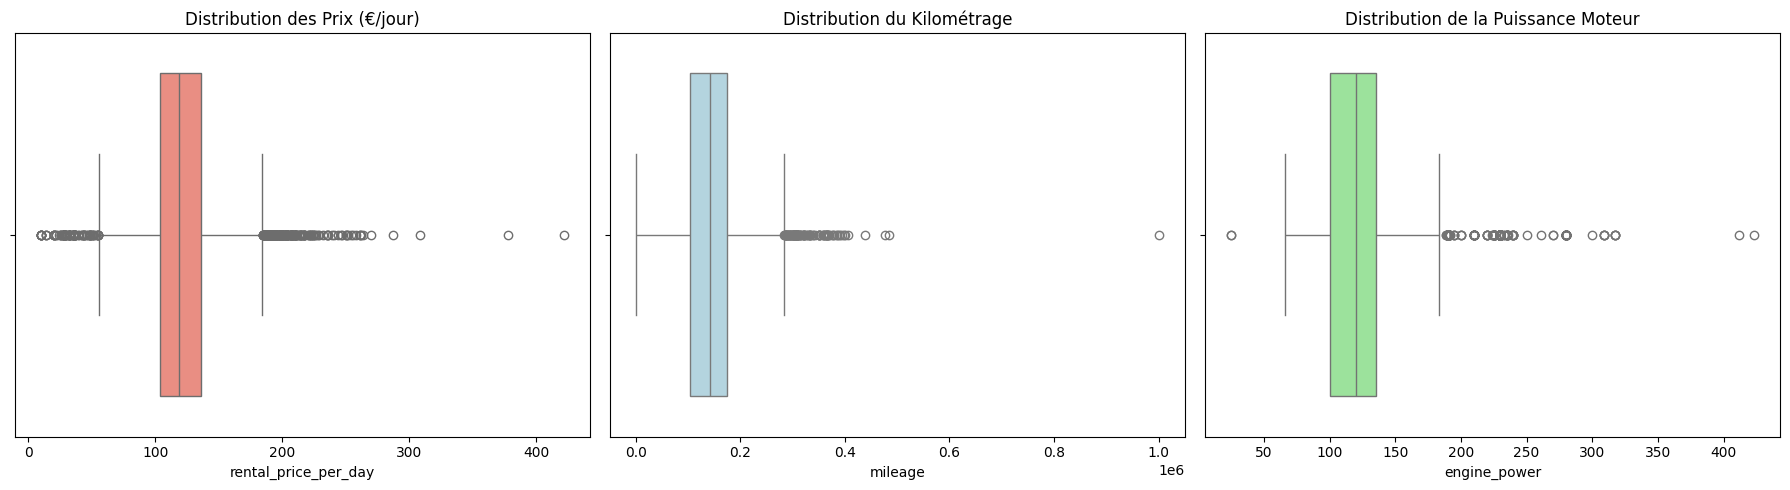

Zoom sur les valeurs les plus élevées :
------------------------------
Prix max : 422 €
Kilométrage max : 1000376 km
Puissance max : 423 ch


In [6]:
# Visualisation des outliers pour décider des suppressions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot des Prix
sns.boxplot(data=df, x='rental_price_per_day', color='salmon', ax=axes[0])
axes[0].set_title("Distribution des Prix (€/jour)")

# Boxplot du Kilométrage
sns.boxplot(data=df, x='mileage', color='lightblue', ax=axes[1])
axes[1].set_title("Distribution du Kilométrage")

# Boxplot de la Puissance
sns.boxplot(data=df, x='engine_power', color='lightgreen', ax=axes[2])
axes[2].set_title("Distribution de la Puissance Moteur")

plt.tight_layout()
plt.show()

# Affichage des valeurs extrêmes pour aider à la décision
print("Zoom sur les valeurs les plus élevées :")
print("-" * 30)
print(f"Prix max : {df['rental_price_per_day'].max()} €")
print(f"Kilométrage max : {df['mileage'].max()} km")
print(f"Puissance max : {df['engine_power'].max()} ch")

In [7]:
# Nettoyage des outliers

print(f"Dimensions avant filtrage : {df.shape}")

df = df[df['mileage'] < 600000]
df = df[df['rental_price_per_day'] < 300]
# df = df[df['engine_power'] < 350]  # à tester dans un second temps

print(f"Dimensions après filtrage : {df.shape}")

Dimensions avant filtrage : (4841, 14)
Dimensions après filtrage : (4837, 14)


---

## **PARTIE 2 | PRÉPROCESSING**

In [ ]:
# Séparation des features (X) et de la target (y)
target_name = 'rental_price_per_day'
X = df.drop(target_name, axis=1)
y = df[target_name]

# Identification des types de colonnes
numeric_features = ['mileage', 'engine_power']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Variables numériques : {numeric_features}")
print(f"Variables catégorielles : {categorical_features}")

# Création des Transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Création du Preprocessor (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Division du dataset (Train / Test Split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

print("Préprocessing terminé !")

Variables numériques : ['mileage', 'engine_power']
Variables catégorielles : ['model_key', 'fuel', 'paint_color', 'car_type', 'private_parking_available', 'has_gps', 'has_air_conditioning', 'automatic_car', 'has_getaround_connect', 'has_speed_regulator', 'winter_tires']
X_train shape: (3869, 13)
X_test shape: (968, 13)
Préprocessing terminé !


---

## **PARTIE 3 | MODÉLISATION (BASELINE)**

In [10]:
# Pipeline complet : Preprocessing -> Modèle
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Entraînement
print("Entraînement du modèle (Linear Regression)...")
model.fit(X_train, y_train)

# Prédictions
print("-" * 50)
print("\nPrédictions sur le jeu de train...")
y_pred_train = model.predict(X_train)
print("Résultats TRAIN (Baseline) :")
print(f"R2 Score : {r2_score(y_train, y_pred_train):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f} €")

print("-" * 50)
print("Prédictions sur le jeu de test...")
y_pred = model.predict(X_test)
print("Résultats TEST (Baseline) :")
print(f"R2 Score : {r2_score(y_test, y_pred):.4f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} €")

Entraînement du modèle (Linear Regression)...
--------------------------------------------------

Prédictions sur le jeu de train...
Résultats TRAIN (Baseline) :
R2 Score : 0.7385
RMSE : 16.76 €
--------------------------------------------------
Prédictions sur le jeu de test...
Résultats TEST (Baseline) :
R2 Score : 0.6984
RMSE : 18.32 €


---

## **PARTIE 4 | OPTIMISATION DU MODÉLE**

### 1. Comparaison de plusieurs modèles avec Cross-Validation

In [11]:
# Liste pour stocker les résultats
results_list = []

# Dictionnaire des modèles et de leurs hyperparamètres à tester
models_to_test = [
    {
        'name': 'Ridge (Régularisation L2)',
        'model': Ridge(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'Lasso (Régularisation L1)',
        'model': Lasso(),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 150],
            'regressor__max_depth': [10, 15],       
            'regressor__min_samples_leaf': [2, 5],  
            'regressor__min_samples_split': [10, 20] 
        }
    },
    {
        'name': 'Bagging Regressor',
        'model': BaggingRegressor(
            estimator=DecisionTreeRegressor(max_depth=15), 
            random_state=42
        ),
        'params': {
            'regressor__n_estimators': [50, 100],
            'regressor__max_samples': [0.8, 1.0] 
        }
    },
    {
        'name': 'AdaBoost',
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [50, 100],
            'regressor__learning_rate': [0.01, 0.1, 1.0]
        }
    }
]

print("Début de la comparaison des modèles avec Cross-Validation...")
print("-" * 80)

best_overall_model = None
best_overall_score = -np.inf

# --- BOUCLE D'ENTRAÎNEMENT ---
for m in models_to_test:
    print(f"Entraînement de : {m['name']}...")
    
    # Création du Pipeline
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', m['model'])
    ])
    
    # Configuration du GridSearch
    grid = GridSearchCV(pipe, m['params'], cv=5, scoring='r2', n_jobs=-1)
    
    # Entraînement
    grid.fit(X_train, y_train)
    
    # Prédictions
    y_pred_test = grid.predict(X_test)
    y_pred_train = grid.predict(X_train)
    
    # Scores
    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_cv = grid.best_score_ # Score moyen de la validation croisée (sur le train set)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # Sauvegarde du meilleur modèle global (basé sur le Test)
    if r2_test > best_overall_score:
        best_overall_score = r2_test
        best_overall_model = grid.best_estimator_
    
    # Calcul de l'écart (gap) d'overfitting
    gap = r2_train - r2_test
    
    # Ajout aux résultats
    results_list.append({
        'Modèle': m['name'],
        'R2 Train': r2_train,
        'R2 Validation (CV)': r2_cv,
        'R2 Test': r2_test,
        'RMSE Test': rmse_test,
        'Overfitting (Train - Test)': gap,
        'Meilleurs Paramètres': str(grid.best_params_)
    })

print("-" * 80)
print("Comparaison terminée !")

Début de la comparaison des modèles avec Cross-Validation...
--------------------------------------------------------------------------------
Entraînement de : Ridge (Régularisation L2)...
Entraînement de : Lasso (Régularisation L1)...
Entraînement de : Random Forest...
Entraînement de : Bagging Regressor...
Entraînement de : AdaBoost...
--------------------------------------------------------------------------------
Comparaison terminée !


In [12]:
# Tableau comparatif des différents modèles entrainés

df_results = pd.DataFrame(results_list)

cols = ['Modèle', 'R2 Train', 'R2 Validation (CV)', 'R2 Test', 'Overfitting (Train - Test)', 'RMSE Test', 'Meilleurs Paramètres']
df_results = df_results[cols]

df_results = df_results.sort_values(by='R2 Test', ascending=False)

print("\nCLASSEMENT DES MODÈLES DÉTAILLÉ :")
display(df_results)


CLASSEMENT DES MODÈLES DÉTAILLÉ :


,Modèle,R2 Train,R2 Validation (CV),R2 Test,Overfitting (Train - Test),RMSE Test,Meilleurs Paramètres
3,Bagging Regressor,0.951685,0.771872,0.773037,0.178648,15.890717,"{'regressor__max_samples': 1.0, 'regressor__n_..."
2,Random Forest,0.891161,0.763793,0.763119,0.128042,16.234212,"{'regressor__max_depth': 15, 'regressor__min_s..."
0,Ridge (Régularisation L2),0.737581,0.726240,0.702621,0.034960,18.189513,{'regressor__alpha': 1.0}
1,Lasso (Régularisation L1),0.736433,0.724860,0.701353,0.035079,18.228245,{'regressor__alpha': 0.01}
4,AdaBoost,0.615093,0.586351,0.599336,0.015757,21.113294,"{'regressor__learning_rate': 0.1, 'regressor__..."


**Le gain de performance du Bagging est minime (+1% de R2) par rapport au Random Forest alors que le coût en stabilité est plus élevé (+5% d'overfitting).** \
L'overfitting du Bagging (presque 18%) semble être problématique pour la mise en production. \
L'overfitting du Random Forest est plus maîtrisé (13%). 

### 2. Sélection et entrainement du modèle final

**Modèle final sélectionné : RANDOM FOREST (arbitrage en faveur de la robustesse)**

In [13]:
print("Entraînement final du modèle choisi (Random Forest)...")

# Meilleurs paramètres identifiés par GridSearch
final_rf_params = {
    'n_estimators': 150,
    'max_depth': 15,
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'random_state': 42
}

# Création du pipeline final
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**final_rf_params))
])

# Entraînement sur tout le jeu de train (X_train, y_train)
final_model.fit(X_train, y_train)

# Vérification de la performance finale
final_score_test = final_model.score(X_test, y_test)
print(f"Score R2 final sur le Test Set : {final_score_test:.4f}")

Entraînement final du modèle choisi (Random Forest)...
Score R2 final sur le Test Set : 0.7631


### 3. Vérification des courbes d'apprentissage

Génération des courbes d'apprentissage...


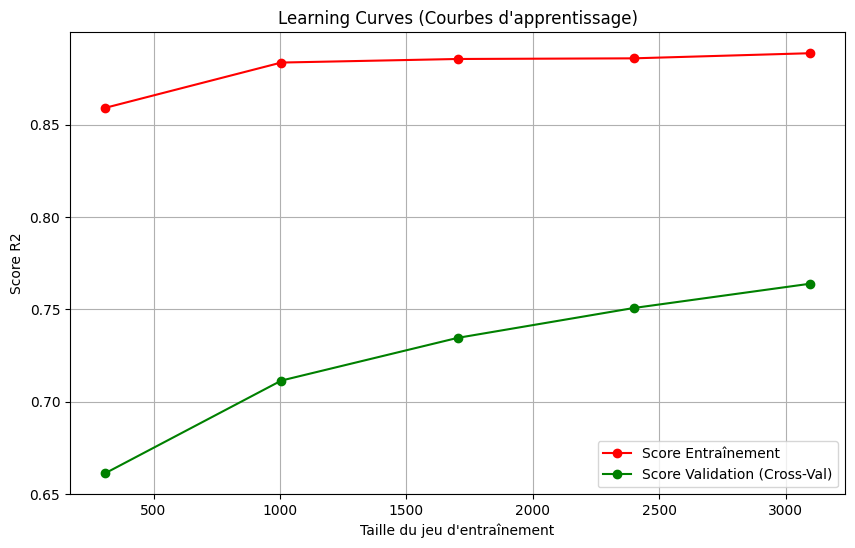

In [14]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score Entraînement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score Validation (Cross-Val)")
    
    plt.title("Learning Curves (Courbes d'apprentissage)")
    plt.xlabel("Taille du jeu d'entraînement")
    plt.ylabel("Score R2")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

print("Génération des courbes d'apprentissage...")
plot_learning_curve(final_model, X_train, y_train)

### 4. Sauvegarde du modèle final

In [15]:
joblib.dump(final_model, 'model.joblib')
print("Modèle Random Forest sauvegardé sous 'model.joblib' !")

Modèle Random Forest sauvegardé sous 'model.joblib' !
